In [13]:
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt

import os
import string
import glob
import re
import random

from collections import Counter

from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

import hdbscan
import umap

In [42]:
%load_ext rpy2.ipython

In [14]:
def run_umap(df: pd.DataFrame, nn: int=15, md: float=0.2, somr: float=0.25, nc=2) -> tuple[np.ndarray,umap.UMAP]:
    umapper = umap.UMAP(
        n_neighbors=nn,
        n_components=nc,
        min_dist=md,
        set_op_mix_ratio=somr,
        metric='euclidean',
        # UMAP figures change with every run if not seeded
        random_state=42
    )

    return (umapper.fit_transform(df), umapper)

In [15]:
# mathematically I think it makes no sense to normalize _before_ scaling. It may
# not even make sense to do it afterwards. It is worth mentioning that the DF
# we're importing here was built using a TFIDF vectorizer trained on ONLY the
# stopwords, so the row sums will be roughly one anyway (because those are the
# only types they count). In actual fact they will be more than one because we
# merge some spelling variations and apparently most texts use some of each
# (??!)

def preproc(df: pd.DataFrame, robust: bool=False, norm: bool=True) -> pd.DataFrame:
    if robust:
        df = RobustScaler().fit_transform(df)
    else:
        df = StandardScaler().fit_transform(df)
    if norm:
        df = Normalizer().fit_transform(df)
    return df

In [16]:
stops_tidy = pd.read_csv('../data/stops_tidy.csv',index_col=0)
stops_tidy

,Translator,Work,Chunk,atqui,aut,autem,certe,ceu,confestim,cum,...,sic,sicut,siquidem,tamquam,ut,utique,velut,veluti,vero,videlicet
0,Bur,Com,quoniam quidem ex calido et frigido et sicco e...,0.0,0.034605,0.190328,0.0,0.0,0.0,0.051908,...,0.000000,0.000000,0.000000,0.0,0.051908,0.077862,0.008651,0.0,0.077862,0.0
1,Bur,Com,sermo non quod nunquam fit in uno eodemque cor...,0.0,0.079463,0.229559,0.0,0.0,0.0,0.061804,...,0.000000,0.000000,0.008829,0.0,0.088292,0.123609,0.008829,0.0,0.026488,0.0
2,Bur,Com,horis anni invenire quartam coniugationem comp...,0.0,0.091264,0.228161,0.0,0.0,0.0,0.000000,...,0.018253,0.000000,0.000000,0.0,0.100391,0.054759,0.018253,0.0,0.091264,0.0
3,Bur,Com,quod necesse est in ea putrefieri omnia incipi...,0.0,0.114119,0.333577,0.0,0.0,0.0,0.017557,...,0.000000,0.000000,0.000000,0.0,0.131675,0.079005,0.000000,0.0,0.017557,0.0
4,Bur,Com,de ipsis per capitula quantum ad presentia uti...,0.0,0.371354,0.234115,0.0,0.0,0.0,0.040365,...,0.000000,0.000000,0.000000,0.0,0.226042,0.121094,0.000000,0.0,0.040365,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1171,Bur,Fid,ostendat quod secundum veritatem est homo cum ...,0.0,0.008708,0.191573,0.0,0.0,0.0,0.060955,...,0.000000,0.000000,0.000000,0.0,0.208988,0.008708,0.000000,0.0,0.008708,0.0
1172,Bur,Fid,causative dicere ut hoc tibi soli peccavi et p...,0.0,0.000000,0.162756,0.0,0.0,0.0,0.019148,...,0.000000,0.000000,0.000000,0.0,0.086165,0.019148,0.009574,0.0,0.028722,0.0
1173,Bur,Fid,condemnavit peccatum in carne ut iustitia legi...,0.0,0.000000,0.229977,0.0,0.0,0.0,0.029997,...,0.000000,0.009999,0.000000,0.0,0.149985,0.019998,0.009999,0.0,0.009999,0.0
1174,Bur,Fid,uxorem suam et concepit et genuit quare propte...,0.0,0.000000,0.170615,0.0,0.0,0.0,0.040145,...,0.000000,0.020072,0.000000,0.0,0.070253,0.010036,0.000000,0.0,0.010036,0.0


In [17]:
Counter(stops_tidy.Work)

Counter({'Com': 24,
         'Pha': 20,
         'Int': 64,
         'Metaph': 76,
         'EthN': 4,
         'Mor': 20,
         'Met': 36,
         'Mirab': 7,
         'Phys': 58,
         'InPar': 161,
         'Mun': 5,
         'Tet': 33,
         'Sig': 3,
         'Pri': 2,
         'InTim': 4,
         'Cael': 26,
         'Gen': 15,
         'P': 3,
         'His': 39,
         '5': 1,
         'Elem': 25,
         'Simp': 120,
         '4': 2,
         'Anim': 19,
         '1': 5,
         '3': 10,
         '2': 1,
         'GenA': 44,
         'Hom': 1,
         'X': 133,
         'Pue': 6,
         'Mat': 66,
         'Men': 9,
         'Alex': 72,
         'EthV': 9,
         'Fid': 53})

In [18]:
Counter(stops_tidy.Translator)

Counter({'Bur': 371,
         'Arist': 35,
         'Anon': 66,
         'Bar': 44,
         'Wil': 554,
         'Jam': 87,
         'Myst': 19})

In [19]:
# Just the feature matrix. No 'Mystery' texts!

tmp = stops_tidy[stops_tidy.Translator != 'Myst'].drop(['Translator','Work','Chunk'], axis=1)
tmp

,atqui,aut,autem,certe,ceu,confestim,cum,dehinc,deinceps,demum,...,sic,sicut,siquidem,tamquam,ut,utique,velut,veluti,vero,videlicet
0,0.0,0.034605,0.190328,0.0,0.0,0.0,0.051908,0.0,0.008651,0.0,...,0.000000,0.000000,0.000000,0.0,0.051908,0.077862,0.008651,0.0,0.077862,0.0
1,0.0,0.079463,0.229559,0.0,0.0,0.0,0.061804,0.0,0.000000,0.0,...,0.000000,0.000000,0.008829,0.0,0.088292,0.123609,0.008829,0.0,0.026488,0.0
2,0.0,0.091264,0.228161,0.0,0.0,0.0,0.000000,0.0,0.009126,0.0,...,0.018253,0.000000,0.000000,0.0,0.100391,0.054759,0.018253,0.0,0.091264,0.0
3,0.0,0.114119,0.333577,0.0,0.0,0.0,0.017557,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.131675,0.079005,0.000000,0.0,0.017557,0.0
4,0.0,0.371354,0.234115,0.0,0.0,0.0,0.040365,0.0,0.008073,0.0,...,0.000000,0.000000,0.000000,0.0,0.226042,0.121094,0.000000,0.0,0.040365,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1171,0.0,0.008708,0.191573,0.0,0.0,0.0,0.060955,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.208988,0.008708,0.000000,0.0,0.008708,0.0
1172,0.0,0.000000,0.162756,0.0,0.0,0.0,0.019148,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.086165,0.019148,0.009574,0.0,0.028722,0.0
1173,0.0,0.000000,0.229977,0.0,0.0,0.0,0.029997,0.0,0.000000,0.0,...,0.000000,0.009999,0.000000,0.0,0.149985,0.019998,0.009999,0.0,0.009999,0.0
1174,0.0,0.000000,0.170615,0.0,0.0,0.0,0.040145,0.0,0.000000,0.0,...,0.000000,0.020072,0.000000,0.0,0.070253,0.010036,0.000000,0.0,0.010036,0.0


# HDBSCAN experiments

The general idea is to cluster in high dimensions with HDBSCAN and then mark those discovered clusters on top of the projected data (clustering in high dimensions gives the clustering algorithm access to more information). The problem, which happens a lot according to HDBSCAN docs, is that our full dimensionality data gets seen as one big cluster.

To compromise, I tried reducing to more than two (but fewer than 50) dimensions with t-SNE and with UMAP. After a lot of parameter jiggling, the UMAP version wins hands down.

In [20]:
tsne_5 = TSNE(n_components=5, perplexity=20,method='exact').fit_transform(preproc(tmp))
tsne_2 = TSNE(n_components=2, perplexity=20).fit_transform(preproc(tmp))

/Users/ben/venv/py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/ben/venv/py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/ben/venv/py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/ben/venv/py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [21]:
# LOTS of magic params :(

clusterer = hdbscan.HDBSCAN(
    metric='euclidean',
    min_samples=5,
    min_cluster_size=10,
    cluster_selection_epsilon=1.95
    #cluster_selection_method='leaf',
    )
clusterer.fit(tsne_5)

color_palette = sns.color_palette('deep', clusterer.labels_.max()+1)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.85, 0.85, 0.85)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
print(f"{clusterer.labels_.max()+1} clusters found")

11 clusters found


In [26]:
cols = stops_tidy[stops_tidy.Translator != 'Myst'].Translator.factorize()[0]

# t-SNE with ground truth

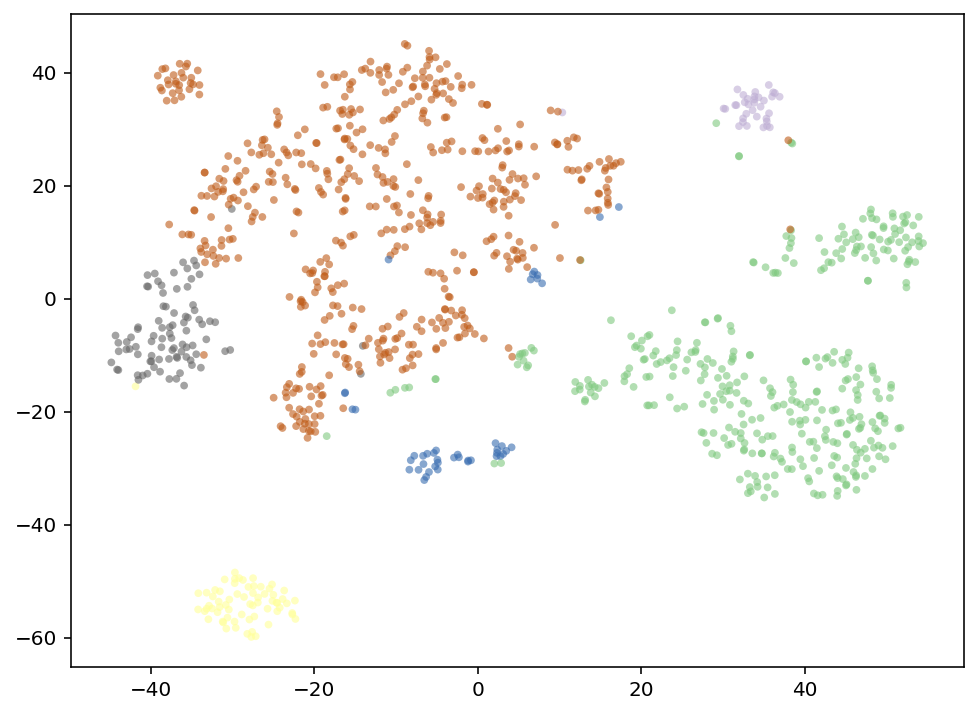

In [38]:
plt.figure(figsize=(8,6),dpi=144)
sc = plt.scatter(*tsne_2.T, s=15, linewidth=0, c=cols,cmap='Accent', alpha=0.6)
plt.show()

# t-SNE with HDBSCAN clusters (from 5 dims)

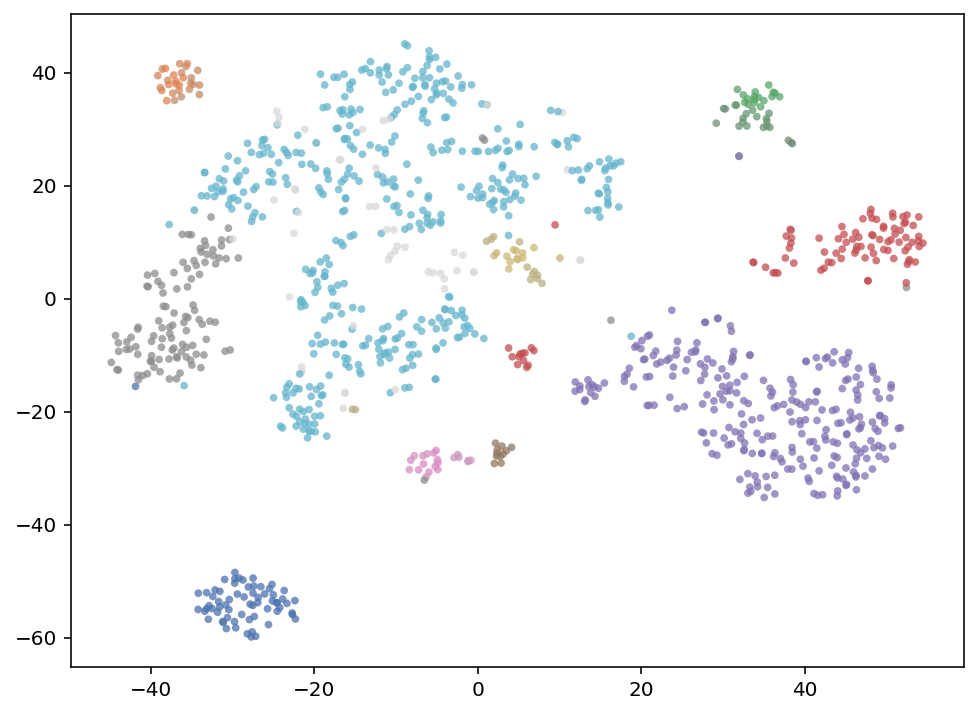

In [39]:
plt.figure(figsize=(8,6),dpi=144)
sc = plt.scatter(*tsne_2.T, s=15, linewidth=0, c=cluster_member_colors, alpha=0.75)
plt.show()

In [30]:
umap_10, _ = run_umap(preproc(tmp), nc=10, nn=7, somr=0.75)
# pure theatrics = the min_dist parameter just makes the points spread out more
# nicely in the projection so it looks better.
umap_2, _ = run_umap(preproc(tmp), nc=2, nn=7, somr=0.75, md=0.4)

In [31]:
# MOAR magic params :( :( :(

clusterer = hdbscan.HDBSCAN(
    metric='euclidean',
    min_samples=5,
    min_cluster_size=10,
    cluster_selection_epsilon=0.6
    #cluster_selection_method='leaf',
    )
clusterer.fit(umap_10)

color_palette = sns.color_palette('deep', clusterer.labels_.max()+1)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.85, 0.85, 0.85)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
print(f"{clusterer.labels_.max()+1} clusters found")

10 clusters found


# UMAP with ground truth

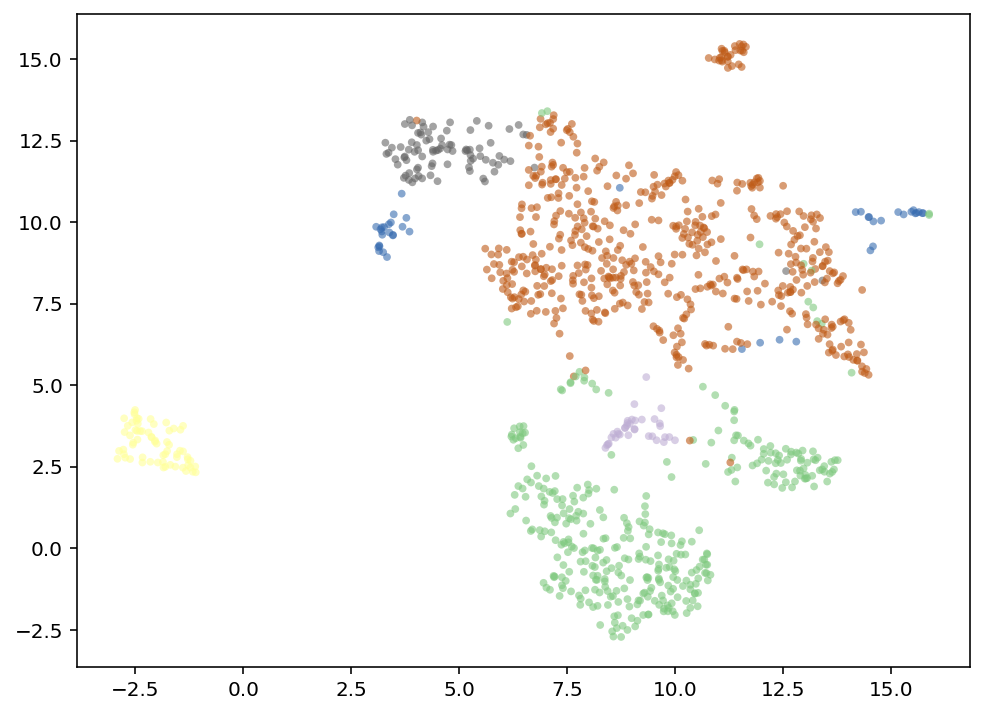

In [37]:
plt.figure(figsize=(8,6),dpi=144)
sc = plt.scatter(*umap_2.T, s=15, linewidth=0, c=cols,cmap='Accent', alpha=0.6)
plt.show()

# UMAP wih HDBSCAN clusters (discovered in 10 dims)

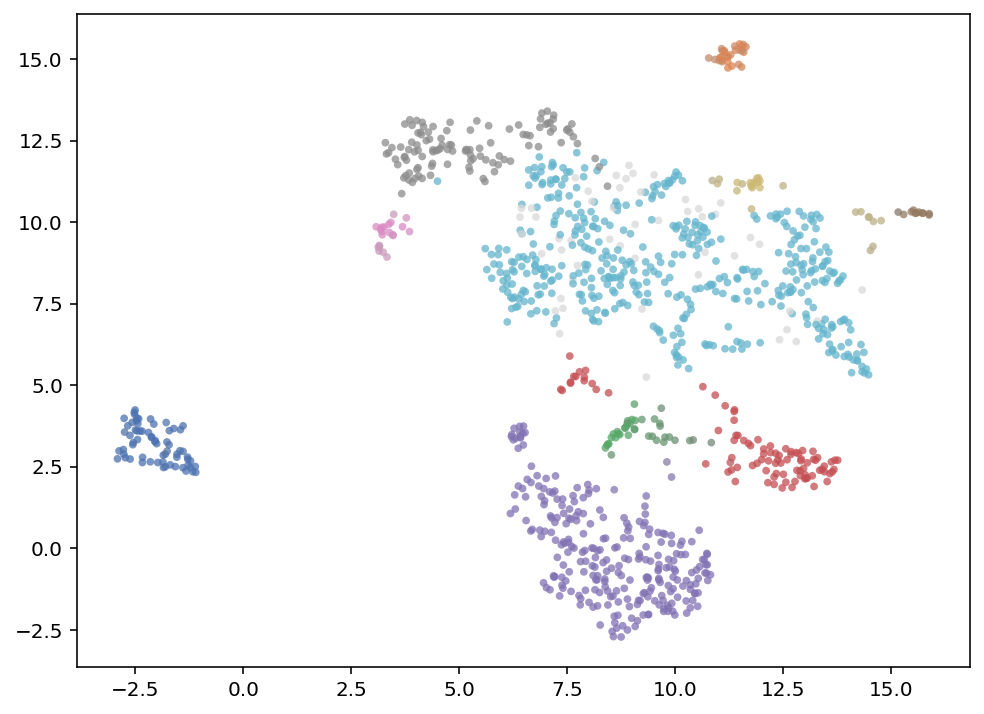

In [36]:
# OK this is impressive...

plt.figure(figsize=(8,6),dpi=144)
sc = plt.scatter(*umap_2.T, s=15, linewidth=0, c=cluster_member_colors, alpha=0.75)
plt.show()

# A quick look at how UMAP hyperparams affect clustering

To make sure our nn param makes sense

In [40]:
frames = []
for i in range(9):
    nn = i+4
    umap_results = stops_tidy[stops_tidy.Translator != 'Myst'][['Translator']].copy()

    umapper = umap.UMAP(
        n_neighbors=nn,
        # project to 2 dimensions
        n_components=2,
        min_dist=0.4,
        set_op_mix_ratio=0.75,
        metric='euclidean',
        # UMAP figures change with every run if not seeded
        random_state=42
    )

    u = umapper.fit_transform(preproc(tmp))
    umap_results['X'], umap_results['Y'] =  u[:,0], u[:,1]
    umap_results['nn'] = nn
    # Now we have an X-Y coordinate applied to every chunk

    frames.append(umap_results)

by_nn = pd.concat(frames)

R[write to console]: Loading required package: sysfonts

R[write to console]: Loading required package: showtextdb



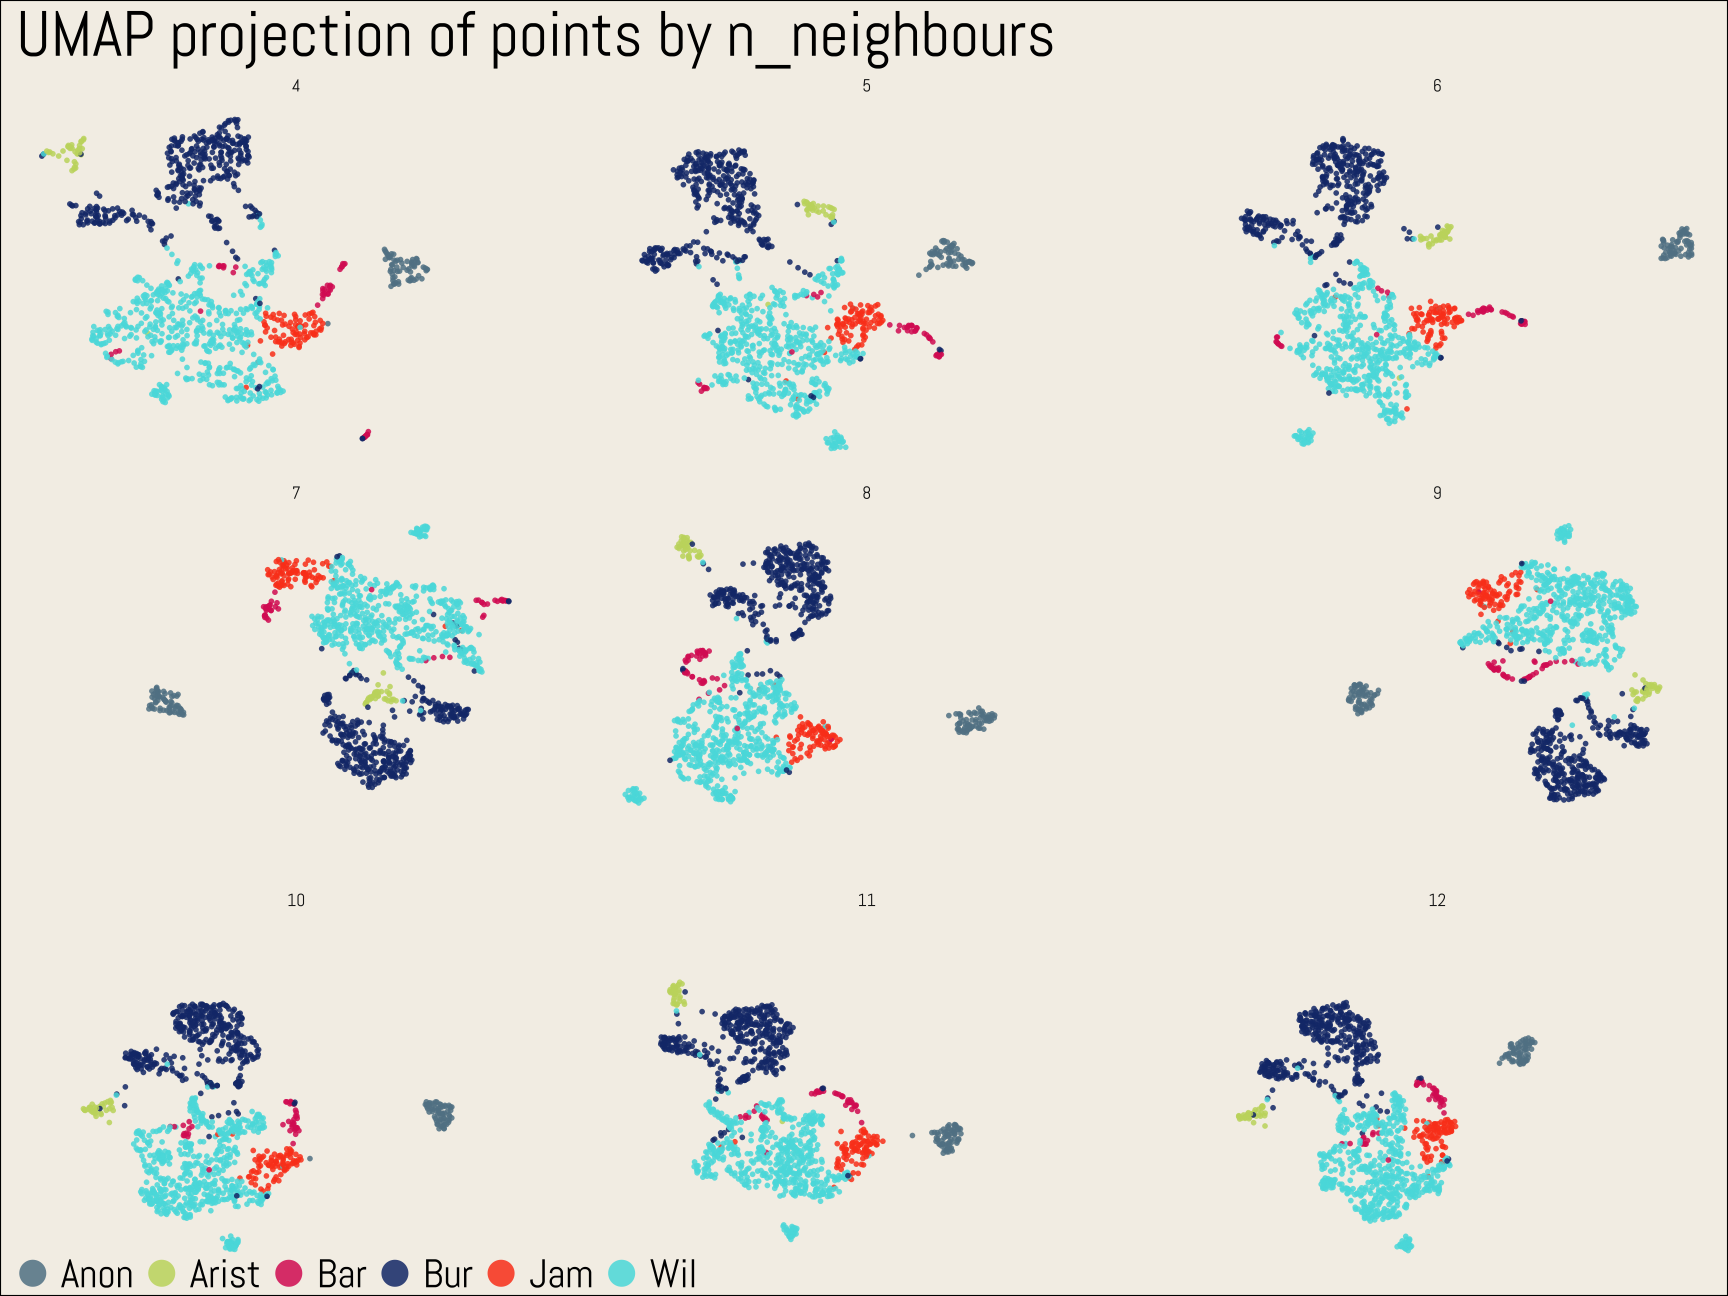

In [43]:
%%R -i by_nn -h 9 -w 12 -u in -r 144

library(ggplot2)
library(paletteer)
library(showtext)
font_add_google("Abel", "fnt")
showtext_auto()

bgcol = '#f4f0e8'
fgcol = 'black'

ggplot(data=by_nn, aes(x=X, y=Y)) +
geom_point(size=1, alpha=0.85, shape=16, aes(color=Translator)) +
theme_minimal() +
scale_colour_paletteer_d("jcolors::pal5") +
theme(plot.title = element_text(margin = margin(b = 50))) +
ggtitle("UMAP projection of points by n_neighbours") +
facet_wrap(vars(nn)) +
guides(color = guide_legend(ncol=6,override.aes =list(size=6))) +
    theme(
        panel.border = element_blank(),
        panel.background = element_rect(fill = bgcol,color=bgcol),
        plot.background = element_rect(fill = bgcol),
        plot.title=element_text(margin=margin(0,0,0,0),size=32),
        legend.title=element_blank(),
        legend.position=c(0.2,0.01),
        legend.text=element_text(size=20),
        legend.key.size = unit(0, 'lines'),
        axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank(),
        text=element_text(family="fnt",color=fgcol),
        panel.grid.minor=element_blank(),
        panel.grid.major=element_blank()
    )


# Part II - Cluster analysis

We attempt to attribute Myst3 to a translator, and also look generally at the cluster behaviour of some authors, noticing that works still do cluster (so some underlying aspect of the work is visible through the translator's style)

In [44]:
wil = stops_tidy[stops_tidy.Translator == 'Wil']
wil

,Translator,Work,Chunk,atqui,aut,autem,certe,ceu,confestim,cum,...,sic,sicut,siquidem,tamquam,ut,utique,velut,veluti,vero,videlicet
206,Wil,Met,ï»¿de primis quidem igitur causis nature et de...,0.0,0.020408,0.275510,0.0,0.0,0.000000,0.010204,...,0.051020,0.020408,0.000000,0.010204,0.040816,0.122449,0.000000,0.0,0.010204,0.000000
207,Wil,Met,radii propter spargi in immensum aut igitur no...,0.0,0.026826,0.330859,0.0,0.0,0.000000,0.035769,...,0.026826,0.008942,0.000000,0.000000,0.035769,0.017884,0.080479,0.0,0.017884,0.000000
208,Wil,Met,generat ipsa aliquando autem sub frigore consi...,0.0,0.052652,0.442277,0.0,0.0,0.000000,0.063182,...,0.021061,0.010530,0.000000,0.000000,0.115834,0.010530,0.052652,0.0,0.021061,0.000000
209,Wil,Met,hyeme in gelu et serenitate a uespera sub asti...,0.0,0.073902,0.348393,0.0,0.0,0.000000,0.031672,...,0.084459,0.021115,0.000000,0.010557,0.084459,0.031672,0.052787,0.0,0.000000,0.000000
210,Wil,Met,apparet enim maximus ens circulus a sole autem...,0.0,0.029137,0.378784,0.0,0.0,0.000000,0.029137,...,0.029137,0.019425,0.009712,0.019425,0.058274,0.038850,0.029137,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1109,Wil,Alex,ait constare corpora et in animalibus et in pl...,0.0,0.027187,0.371562,0.0,0.0,0.000000,0.000000,...,0.063437,0.009062,0.000000,0.027187,0.135937,0.027187,0.000000,0.0,0.000000,0.000000
1110,Wil,Alex,ab ipsa liquabilia autem aqua ait esse quaecum...,0.0,0.029206,0.445386,0.0,0.0,0.007301,0.036507,...,0.021904,0.000000,0.000000,0.007301,0.094918,0.021904,0.000000,0.0,0.000000,0.000000
1111,Wil,Alex,non liquabilia enim exhalabilium flammae facti...,0.0,0.164371,0.493114,0.0,0.0,0.000000,0.057530,...,0.000000,0.008219,0.000000,0.000000,0.106841,0.032874,0.000000,0.0,0.000000,0.016437
1112,Wil,Alex,caliditate vinum autem calidum propter pepansi...,0.0,0.070151,0.324449,0.0,0.0,0.000000,0.026307,...,0.026307,0.008769,0.008769,0.000000,0.140302,0.008769,0.008769,0.0,0.000000,0.008769


Same method multiple times. 'Train' the UMAP clusterer on some data (either all the works or the works of one author) and then project the points from Myst3 onto that same embedding space using the 'trained' clusterer.

In [63]:
wil = stops_tidy[stops_tidy.Translator == 'Wil']
wil_X = wil.drop(['Translator','Work','Chunk'], axis=1)
umap_cols, umapper = run_umap(preproc(wil_X,robust=True,norm=True),md=0.2,nn=8)
wil.insert(2, "Y", umap_cols[:,1])
wil.insert(2, "X", umap_cols[:,0])

In [64]:
myst3 = stops_tidy.query("Work=='3' & Translator=='Myst'")
umap_cols = umapper.transform(myst3.drop(['Translator','Work','Chunk'], axis=1))
myst3.insert(2, "Y", umap_cols[:,1])
myst3.insert(2, "X", umap_cols[:,0])

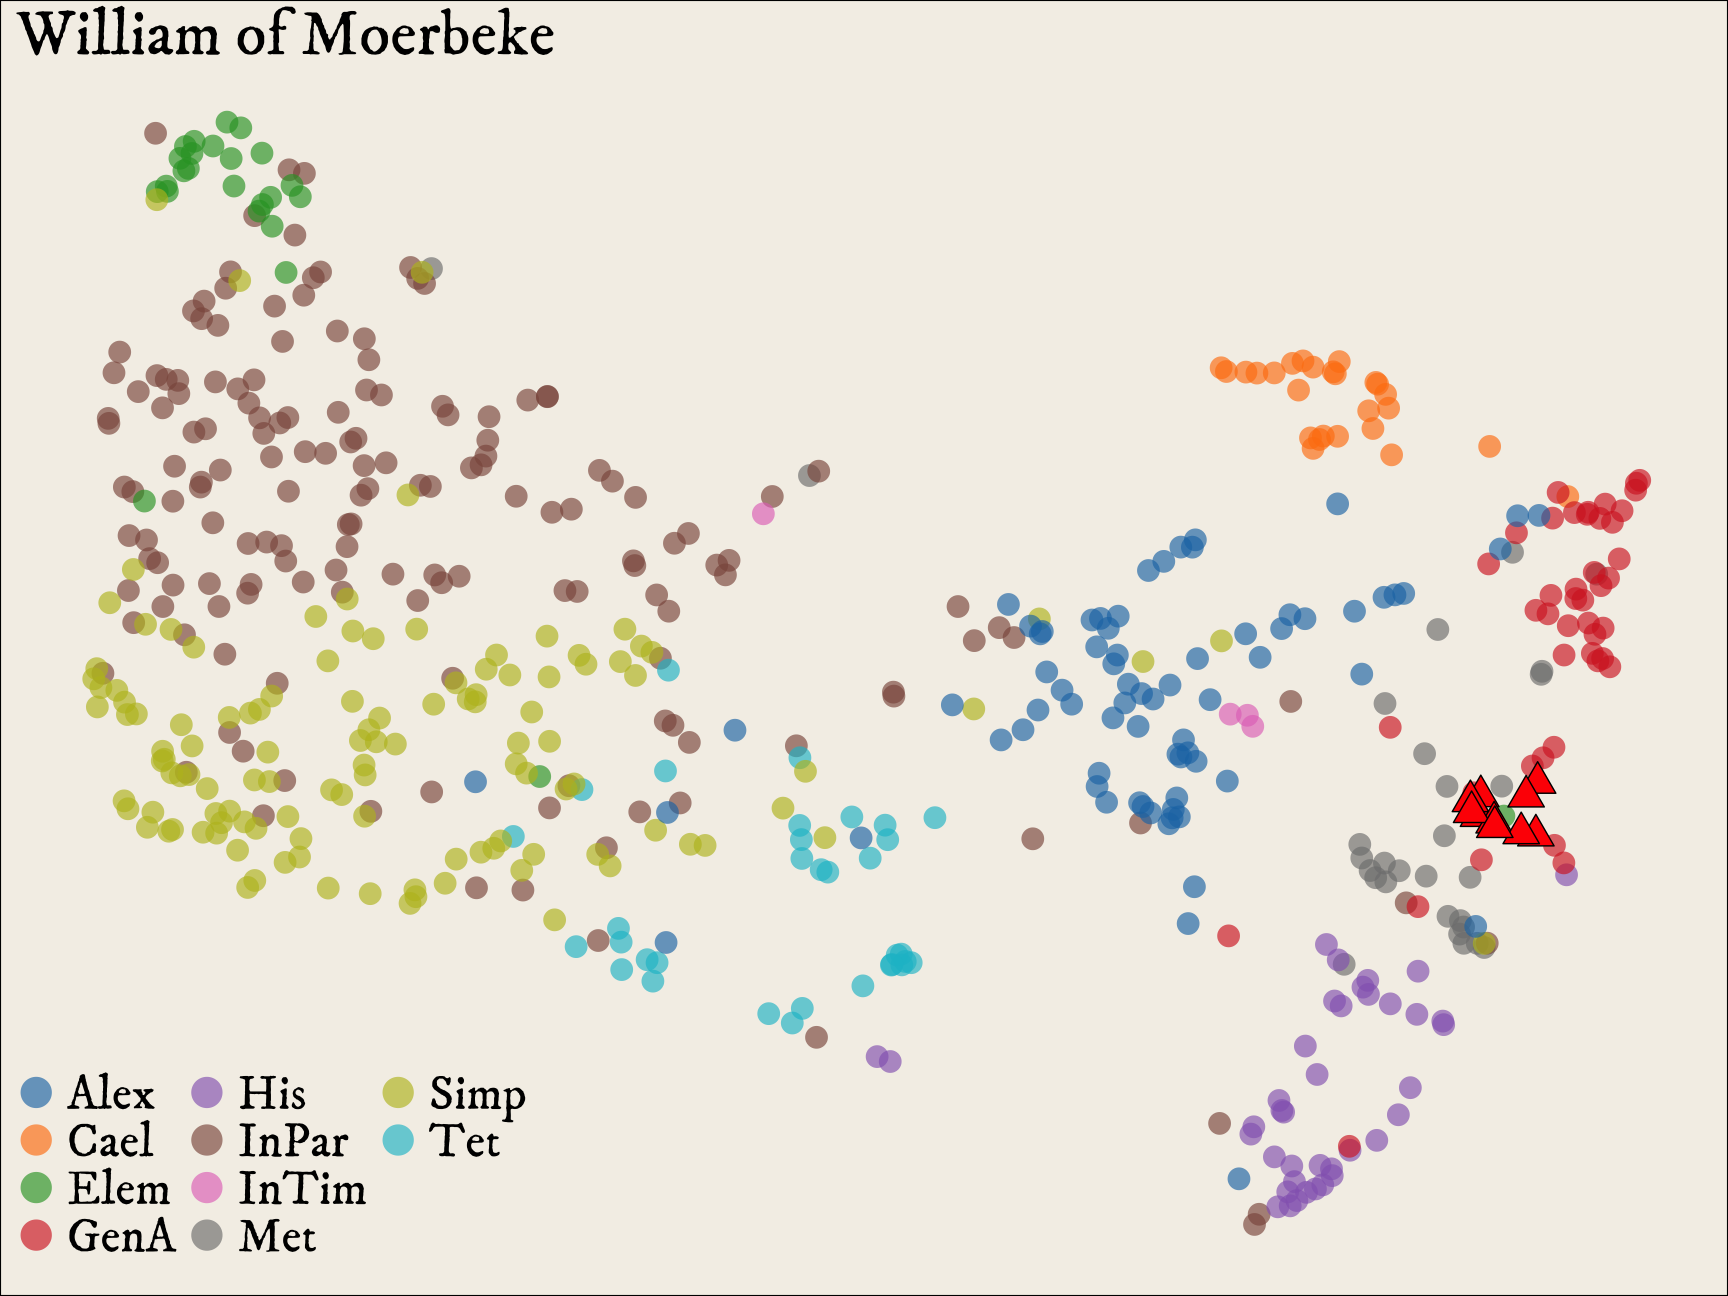

In [66]:
%%R -i wil,myst3 -h 9 -w 12 -u in -r 144

library(ggplot2)
library(paletteer)
library(showtext)
font_add_google("IM Fell DW Pica", "fnt")
showtext_auto()

bgcol = '#f4f0e8'
fgcol = 'black'

ggplot(data=wil, aes(x=X, y=Y)) +
geom_point(size=5, alpha=0.65, shape=16, aes(color=Work)) +
geom_point(data=myst3, size=6, shape=24, color='black', fill='red', alpha=1) +
theme_minimal() +
scale_colour_paletteer_d("ggsci::category20_d3") +
theme(plot.title = element_text(margin = margin(b = 50))) +
ggtitle("William of Moerbeke") +
guides(color = guide_legend(ncol=3,override.aes =list(size=7))) +
    theme(
        panel.border = element_blank(),
        panel.background = element_rect(fill = bgcol,color=bgcol),
        plot.background = element_rect(fill = bgcol),
        plot.title=element_text(margin=margin(0,0,0,0),size=32),
        legend.title=element_blank(),
        legend.position=c(0.15,0.1),
        legend.text=element_text(size=24),
        legend.key.size = unit(0, 'lines'),
        axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank(),
        text=element_text(family="fnt",color=fgcol),
        panel.grid.minor=element_blank(),
        panel.grid.major=element_blank()
    )

In [49]:
# No real chance Burgundio was the Myst3 translator so we don't add those points.

bur = stops_tidy[stops_tidy.Translator == 'Bur']
bur_X = bur.drop(['Translator','Work','Chunk'], axis=1)
umap_cols, _ = run_umap(preproc(bur_X,robust=True,norm=True),md=0.3,nn=10,somr=0.5)
bur.insert(2, "Y", umap_cols[:,1])
bur.insert(2, "X", umap_cols[:,0])

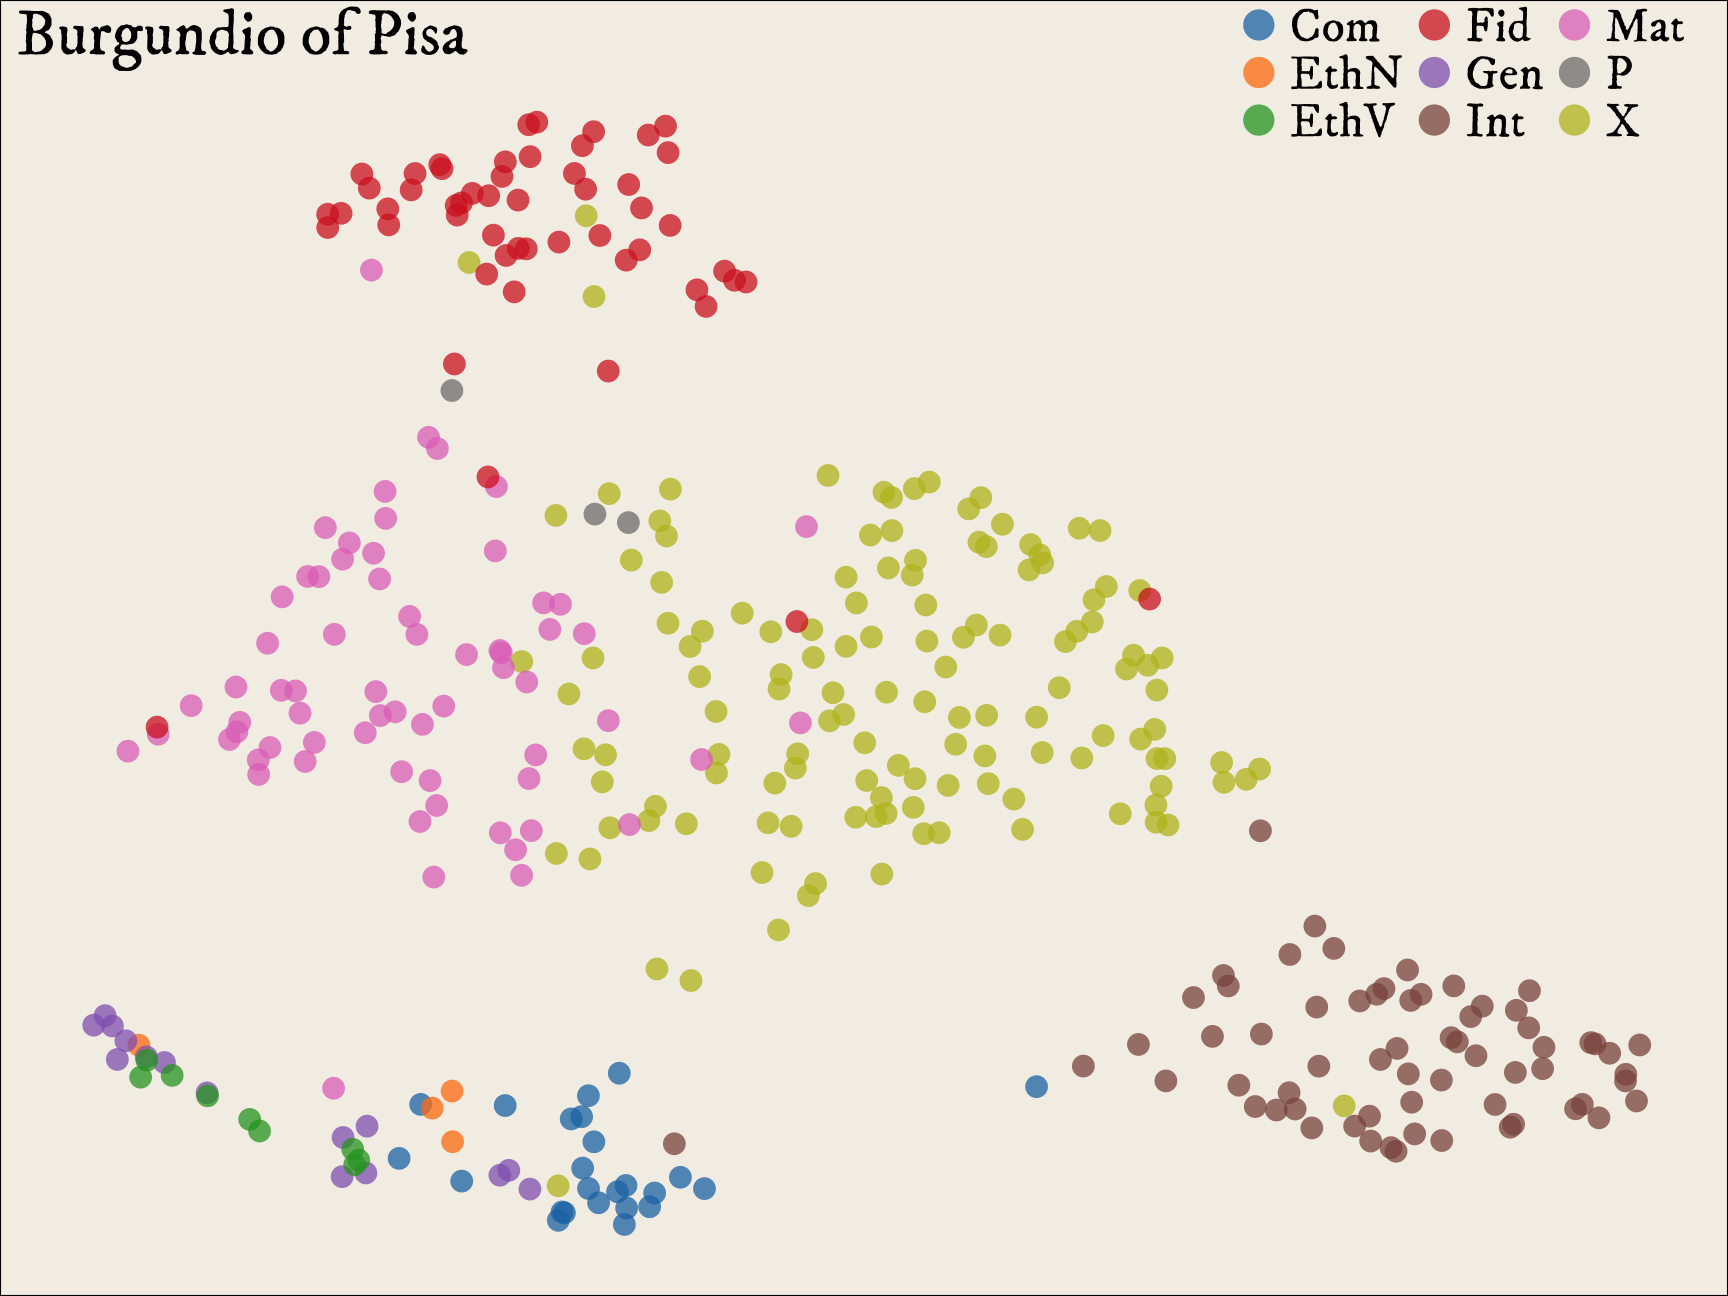

In [50]:
%%R -i bur -h 9 -w 12 -u in -r 144

library(ggplot2)
library(paletteer)
library(showtext)
font_add_google("IM Fell DW Pica", "fnt")
showtext_auto()

bgcol = '#f4f0e8'
fgcol = 'black'

ggplot(data=bur, aes(x=X, y=Y)) +
geom_point(size=5, alpha=0.75, shape=16, aes(color=Work)) +
theme_minimal() +
scale_colour_paletteer_d("ggsci::category20_d3") +
theme(plot.title = element_text(margin = margin(b = 50))) +
ggtitle("Burgundio of Pisa") +
guides(color = guide_legend(ncol=3,override.aes =list(size=7))) +
    theme(
        panel.border = element_blank(),
        panel.background = element_rect(fill = bgcol,color=bgcol),
        plot.background = element_rect(fill = bgcol),
        plot.title=element_text(margin=margin(0,0,0,0),size=32),
        legend.title=element_blank(),
        legend.position=c(0.85,1),
        legend.text=element_text(size=24),
        legend.key.size = unit(0, 'lines'),
        axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank(),
        text=element_text(family="fnt",color=fgcol),
        panel.grid.minor=element_blank(),
        panel.grid.major=element_blank()
    )

In [67]:
bart = stops_tidy[stops_tidy.Translator == 'Bar']
bart_X = bart.drop(['Translator','Work','Chunk'], axis=1)
umap_cols, umapper = run_umap(preproc(bart_X,robust=True,norm=True),md=0.2,nn=8)
bart.insert(2, "Y", umap_cols[:,1])
bart.insert(2, "X", umap_cols[:,0])

In [68]:
# Yes, we do need to redo this projection of Myst3 every time

myst3 = stops_tidy.query("Work=='3' & Translator=='Myst'")
umap_cols = umapper.transform(myst3.drop(['Translator','Work','Chunk'], axis=1))
myst3.insert(2, "Y", umap_cols[:,1])
myst3.insert(2, "X", umap_cols[:,0])

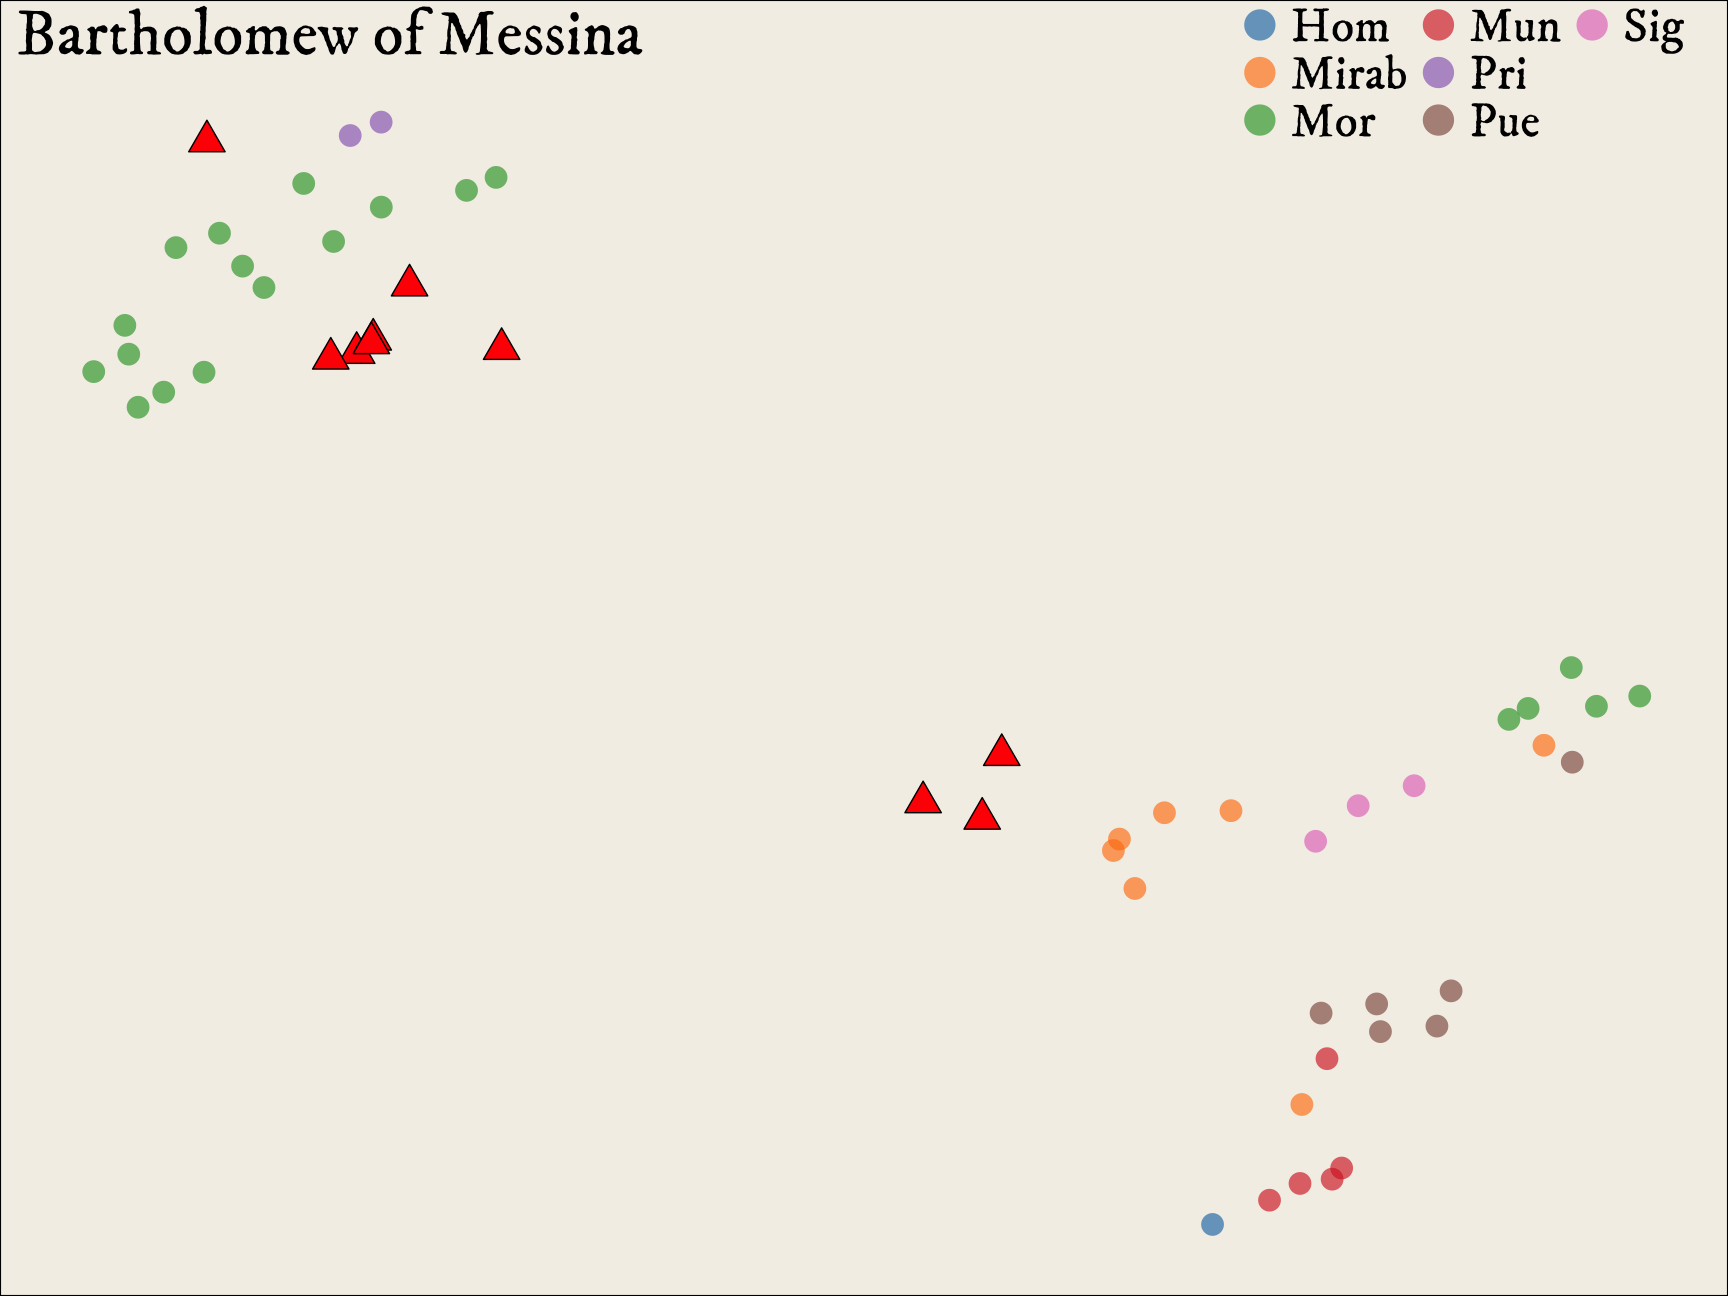

In [69]:
%%R -i bart,myst3 -h 9 -w 12 -u in -r 144

library(ggplot2)
library(paletteer)
library(showtext)
font_add_google("IM Fell DW Pica", "fnt")
showtext_auto()

bgcol = '#f4f0e8'
fgcol = 'black'

ggplot(data=bart, aes(x=X, y=Y)) +
geom_point(size=5, alpha=0.65, shape=16, aes(color=Work)) +
geom_point(data=myst3, size=6, shape=24, color='black', fill='red', alpha=1) +
theme_minimal() +
scale_colour_paletteer_d("ggsci::category20_d3") +
theme(plot.title = element_text(margin = margin(b = 50))) +
ggtitle("Bartholomew of Messina") +
guides(color = guide_legend(ncol=3,override.aes =list(size=7))) +
    theme(
        panel.border = element_blank(),
        panel.background = element_rect(fill = bgcol,color=bgcol),
        plot.background = element_rect(fill = bgcol),
        plot.title=element_text(margin=margin(0,0,0,0),size=32),
        legend.title=element_blank(),
        legend.position=c(0.85,1),
        legend.text=element_text(size=24),
        legend.key.size = unit(0, 'lines'),
        axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank(),
        text=element_text(family="fnt",color=fgcol),
        panel.grid.minor=element_blank(),
        panel.grid.major=element_blank()
    )

In [70]:
all = stops_tidy[stops_tidy.Translator != 'Myst'].copy()
all_X = all.drop(['Translator','Work','Chunk'], axis=1)
umap_cols, umapper = run_umap(preproc(all_X), nc=2, nn=7, somr=0.75, md=0.4)
all.insert(2, "Y", umap_cols[:,1])
all.insert(2, "X", umap_cols[:,0])

In [71]:
myst3 = stops_tidy.query("Work=='3' & Translator=='Myst'")
umap_cols = umapper.transform(myst3.drop(['Translator','Work','Chunk'], axis=1))
myst3.insert(2, "Y", umap_cols[:,1])
myst3.insert(2, "X", umap_cols[:,0])

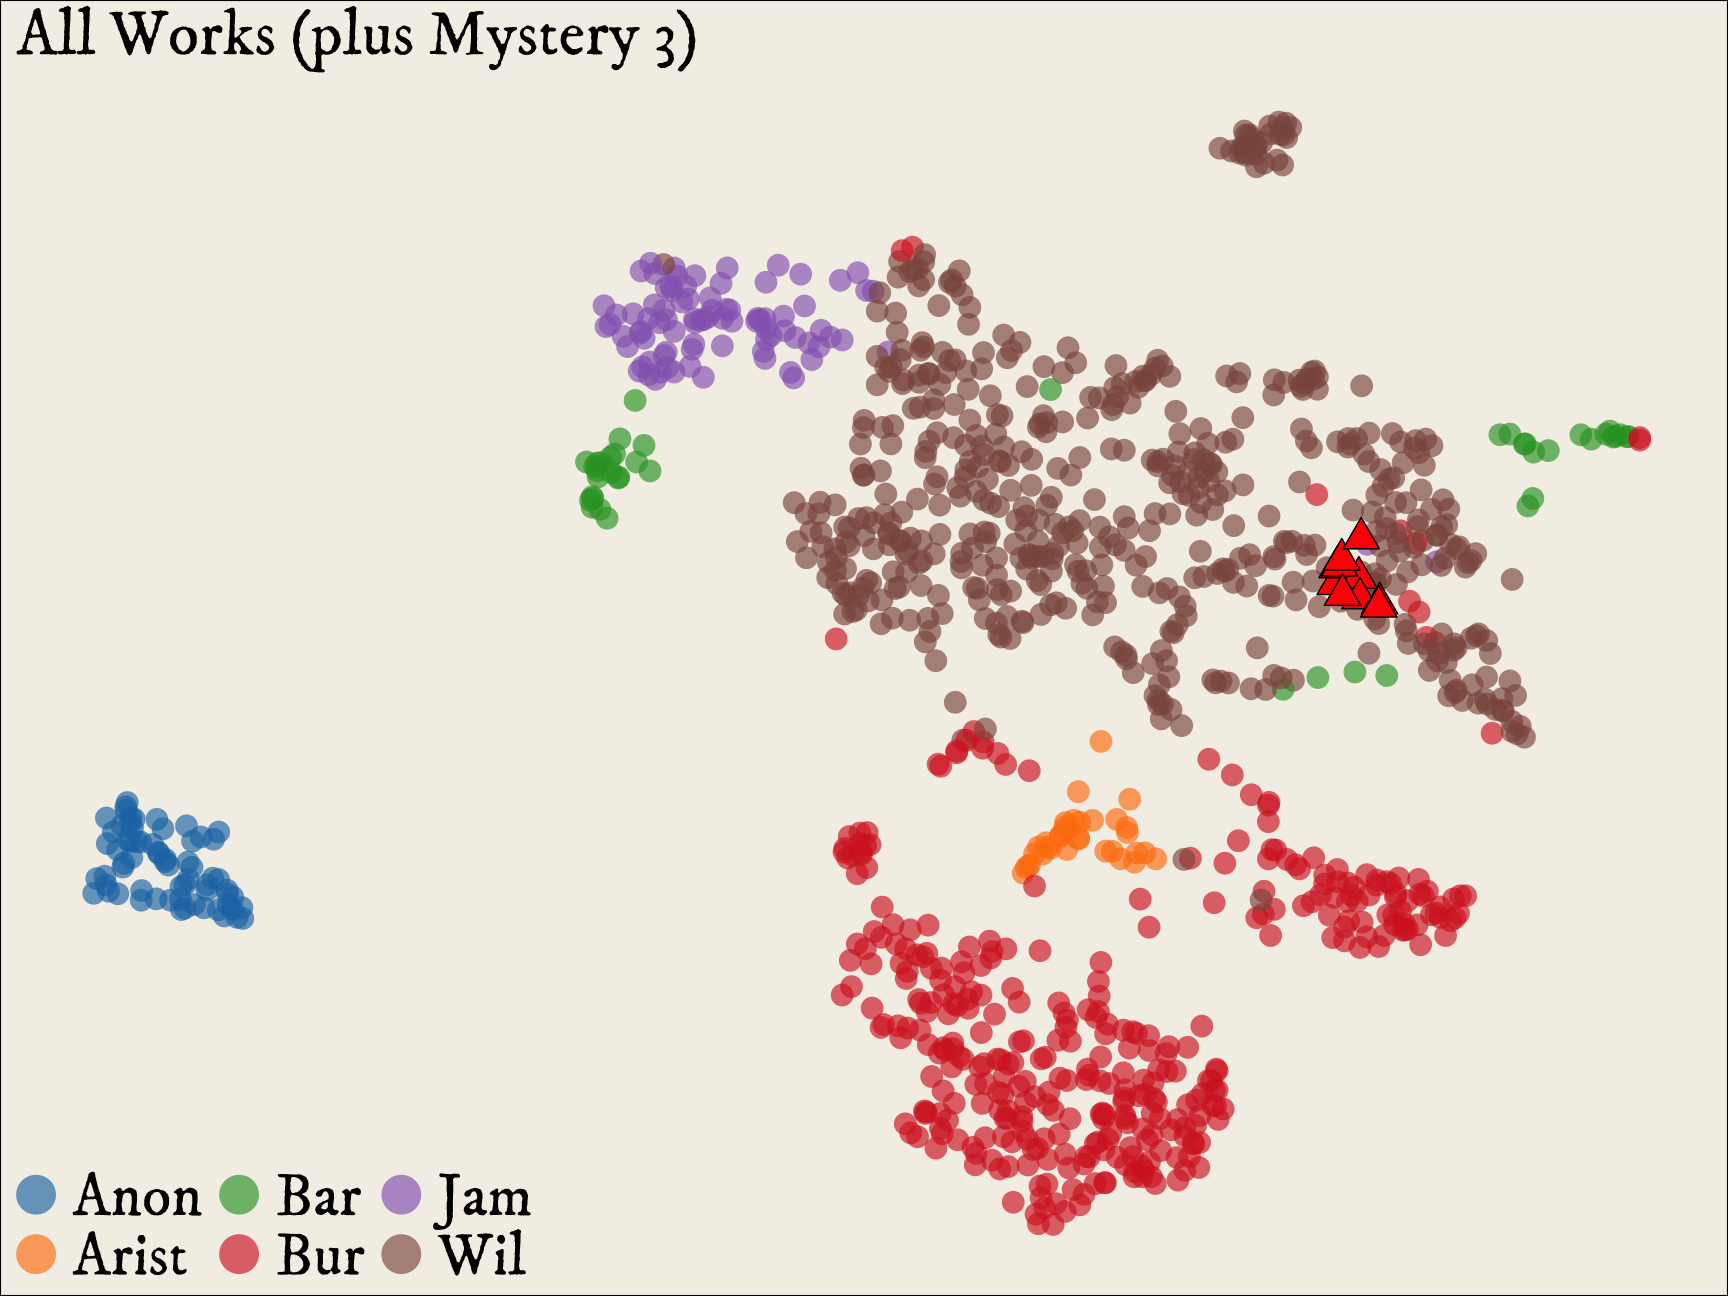

In [72]:
%%R -i all,myst3 -h 9 -w 12 -u in -r 144

library(ggplot2)
library(paletteer)
library(showtext)
font_add_google("IM Fell DW Pica", "fnt")
showtext_auto()

bgcol = '#f4f0e8' # antique paper
fgcol = 'black'

ggplot(data=all, aes(x=X, y=Y)) +
geom_point(size=5, alpha=0.65, shape=16, aes(color=Translator)) +
geom_point(data=myst3, size=6, shape=24, color='black', fill='red', alpha=1) +
theme_minimal() +
scale_colour_paletteer_d("ggsci::category20_d3") +
theme(plot.title = element_text(margin = margin(b = 50))) +
ggtitle("All Works (plus Mystery 3)") +
guides(color = guide_legend(ncol=3,override.aes =list(size=9))) +
    theme(
        panel.border = element_blank(),
        panel.background = element_rect(fill = bgcol,color=bgcol),
        plot.background = element_rect(fill = bgcol),
        plot.title=element_text(margin=margin(0,0,0,0),size=32),
        legend.title=element_blank(),
        legend.position=c(0.15,0.05),
        legend.text=element_text(size=30),
        legend.key.size = unit(0, 'lines'),
        axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank(),
        text=element_text(family="fnt",color=fgcol),
        panel.grid.minor=element_blank(),
        panel.grid.major=element_blank()
    )